# Hand Gesture Recognition

This code is based on an assignment developed by Prof. Lisa Zhang. 

## Data Collection

Datasets like MNIST and CIFAR are often used as toy examples, both by students and by researchers testing new machine learning models. In the real world, getting a clean data set is never that easy. More than half the work in applying machine learning is finding, gathering, cleaning, and formatting your data set.

### American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. This code focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Building a CNN

### Data Loading and Splitting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/MyDrive/Gesture_Dataset.zip

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np

I will split the data into 70% training, 15% validation and 15% testing using the random_split function in pytorch.

It shuffles the pictures and selects some of the images to be in training, others in validation and the rest in testing. Note that the manual seed is to ensure the reproducibility of the results.

In [ ]:
dataset = torchvision.datasets.ImageFolder('/content/Gesture_Dataset',transform=transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor()]))
train_sampler,val_sampler,test_sampler=torch.utils.data.random_split(dataset,[1703,364,364],generator=torch.Generator().manual_seed(42))


def get_data_loader(batch_size):

    train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, num_workers=0, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_sampler, batch_size=batch_size,num_workers=0, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=batch_size,num_workers=0, shuffle=True)

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

### Model Building and Sanity Checking

The architecture that I chose is: 2 convolutional layers, 2 pooling layers and 3 linear fully connected layers (similar to LeNet-5). I figured since this is a simple and effective way to start off our prediction model, I can modify it in the hyperparameter tuning part to get a faster or better model.

As for the pooling layers, we need to consolidate the information and reduce the size of the initial image, for this reason, I used max pooling with kernels of size 2x2 and a stride of 2. I applied relu as the activation function because it is more effective than sigmoid and tanh for this case.

For the number of channels, I started with the first convolutional layer of 3 channels (because our input is an image), then the ouput channels are 5, feed this into the pooling layers and then into the second convolutional layer of output channels 10, then feed it into another pooling layer and then into our fully connected layers. This could be optimized in the second part of this code.

In [ ]:
class HandGestureClassifer(nn.Module):
  def __init__(self):
    super(HandGestureClassifer, self).__init__()
    self.name="HandGesture"
    self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
    self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
    self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
    self.fc1 = nn.Linear(10*53*53, 32)
    self.fc2 = nn.Linear(32, 9)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 10*53*53)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### Training Code

Since this is a multiclass classification problem, the loss function will be cross entropy loss, and I will use nn.CrossEntropyLoss() because it is more effectively calculating the loss. The optimizer is SGD because it reduces the cost of computing the gradient when we have batches and we have batches of 64.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
    
def normalize_label(labels):
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels
    
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_accuracy=0.0
    total_epoch = 0
    for i, data in enumerate(loader,0):
      inputs, labels=data
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      corr=(torch.argmax(outputs, axis=1)== labels)
      total_accuracy += int(corr.sum())
      total_loss += loss.item()
      total_epoch += len(labels)
    err = 1-(float(total_accuracy) / total_epoch)
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    torch.manual_seed(1000)
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_accuracy = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader,0):
          inputs, labels=data
          if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          corr=(torch.argmax(outputs, axis=1) == labels)
          total_train_accuracy += int(corr.sum())
          total_train_loss += loss.item()
          total_epoch += len(labels)
        train_err[epoch] = 1-(float(total_train_accuracy) / total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+"Validation err: {}, Validation loss: {}").format(epoch + 1,train_err[epoch],train_loss[epoch],val_err[epoch],val_loss[epoch]))

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
HandGestureNet= HandGestureClassifer()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_net(HandGestureNet, batch_size=64, learning_rate=0.01, num_epochs=30)

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: Train err: 0.8907809747504404, Train loss: 2.1996813085344105 |Validation err: 0.9148351648351648, Validation loss: 2.197457790374756
Epoch 2: Train err: 0.8631826189078098, Train loss: 2.175135435881438 |Validation err: 0.7335164835164836, Validation loss: 2.1007827123006186
Epoch 3: Train err: 0.6095126247798004, Train loss: 1.6753307404341522 |Validation err: 0.6153846153846154, Validation loss: 1.5234846870104473
Epoch 4: Train err: 0.4398120963006459, Train loss: 1.2276701750578705 |Validation err: 0.37362637362637363, Validation loss: 1.085977206627528
Epoch 5: Train err: 0.34527304756312394, Train loss: 1.0077371001243591 |Validation err: 0.36813186813186816, Validation loss: 1.0222512284914653
Epoch 6: Train err: 0.3217850851438637, Train loss: 0.9439143096959149 |Validation err: 0.30219780219780223, Validation loss: 0.9239141643047333
Epoch 7: Train err: 0.29183793305930705, Train loss: 0.875808718027892 |Validation err: 0.3214285714285714, Validation loss: 0.96071578

The model is overfitting because the training error is getting very close to 0 by the end of the 30th epoch, I could consider this a sanity check, and for preventing this overfitting, I would need to either stop the epochs at an earlier stage, or change the architecture, or tune the hyperparameters (which will be done in the next part).

In [ ]:
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

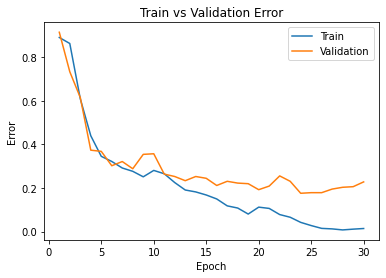

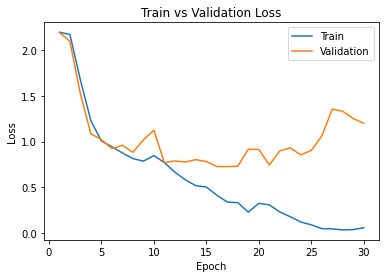

In [ ]:
from sklearn.model_selection import learning_curve
model_path = get_model_name("HandGesture", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### “Overfit” to a Small Dataset

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

In [ ]:
!unzip /content/gdrive/MyDrive/Hassoune_1007806705.zip

Archive:  /content/gdrive/MyDrive/Hassoune_1007806705.zip
replace __MACOSX/._Hassoune_1007806705? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset2 = torchvision.datasets.ImageFolder('/content/Hassoune_1007806705',transform=transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor()]))

In [ ]:
#train_loader2, val_loader2, test_loader2 = get_data_loader(batch_size=20)

torch.manual_seed(3)
torch.cuda.empty_cache()

train_loader2=torch.utils.data.DataLoader(dataset2, batch_size=54, num_workers=0)
HandGestureNet=HandGestureClassifer()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

optimizer = optim.Adam(HandGestureNet.parameters(), lr =0.001) #note i changed to Adam because it takes into account several things such as adaptive learning rate, momentum... and this will be helpful to prove the overfitting.
criterion = nn.CrossEntropyLoss()

train_err = np.zeros(200)
train_loss = np.zeros(200)
val_err = np.zeros(200)
val_loss = np.zeros(200)


for epoch in range(200):
  total_train_loss = 0.0
  total_train_err = 0.0
  total_train_accuracy = 0.0
  total_epoch = 0
  for images,labels in iter(train_loader2):
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = HandGestureNet(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    corr=(torch.argmax(outputs, axis=1) == labels)
    total_train_accuracy += int(corr.sum())
    total_train_loss += loss.item()
    total_epoch+=len(labels)
  train_err[epoch] = 1-(float(total_train_accuracy) / total_epoch)
  train_loss[epoch] = float(total_train_loss) / (27)

  print(("Epoch {}: Train err: {}, Train loss: {}").format(epoch + 1,train_err[epoch],train_loss[epoch]))

CUDA is available!  Training on GPU ...
Epoch 1: Train err: 0.8888888888888888, Train loss: 0.08174761136372884
Epoch 2: Train err: 0.8888888888888888, Train loss: 0.08391106570208515
Epoch 3: Train err: 0.8888888888888888, Train loss: 0.08180553824813278
Epoch 4: Train err: 0.7777777777777778, Train loss: 0.08096106847127278
Epoch 5: Train err: 0.8888888888888888, Train loss: 0.0800625483194987
Epoch 6: Train err: 0.7777777777777778, Train loss: 0.0792677225889983
Epoch 7: Train err: 0.7407407407407407, Train loss: 0.07956193111560962
Epoch 8: Train err: 0.7777777777777778, Train loss: 0.07866046163770887
Epoch 9: Train err: 0.8518518518518519, Train loss: 0.07781130296212656
Epoch 10: Train err: 0.7037037037037037, Train loss: 0.07680047882927789
Epoch 11: Train err: 0.6666666666666667, Train loss: 0.07546577630219636
Epoch 12: Train err: 0.5555555555555556, Train loss: 0.07353507589410853
Epoch 13: Train err: 0.5555555555555556, Train loss: 0.07085085798192907
Epoch 14: Train err: 0

The model is capable of overfitting since the error for the training is 0 and the loss is decreasing and is very small.

### Hyperparameter Search

There is a list of hyperparameters we could choose from to tune our model:

- Momentum
- Batch size
- Introducing dropout
- Learning rate
- Number of epochs
- Number of hidden units (related to the model architecture)
...

However, for this case, I think the hyperparameters that are most worth tuning are 1) the number of convolutional and pooling layers, 2) the learning rate, 3) number of epochs.

**HYPERPARAMETER SETTINGS 1: decrease batch size, decrease learning rate (to decrease our learning rate we would need to increase the batch size)**

In [ ]:
HandGestureNet=HandGestureClassifer()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_net(HandGestureNet, batch_size=32, learning_rate=0.001, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch 1: Train err: 0.8708162066940692, Train loss: 2.198724066769635 |Validation err: 0.9395604395604396, Validation loss: 2.2115725676218667
Epoch 2: Train err: 0.8602466236054023, Train loss: 2.1789257526397705 |Validation err: 0.8928571428571429, Validation loss: 2.1853817105293274
Epoch 3: Train err: 0.7991779213153258, Train loss: 2.125986094828005 |Validation err: 0.7417582417582418, Validation loss: 2.0251399278640747
Epoch 4: Train err: 0.6746917204932472, Train loss: 1.8999937551992911 |Validation err: 0.6016483516483517, Validation loss: 1.6418369213740032
Epoch 5: Train err: 0.5960070463887257, Train loss: 1.634865442911784 |Validation err: 0.5576923076923077, Validation loss: 1.4360025823116302
Epoch 6: Train err: 0.5096887844979447, Train loss: 1.4272616019955389 |Validation err: 0.5219780219780219, Validation loss: 1.3838746945063274
Epoch 7: Train err: 0.43687610099823837, Train loss: 1.2679614270174946 |Validation err: 0.42307692

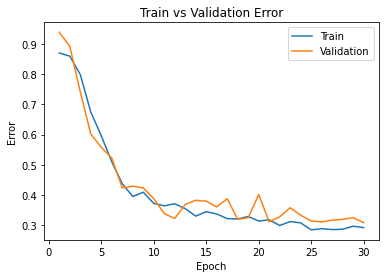

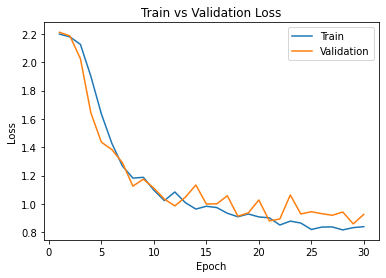

In [ ]:
model_path2 = get_model_name("HandGesture", batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(model_path2)

The validation curves are very spiky, which shows that these hyperparameter settings did not improve the model's prediction.

**HYPERPARAMETER SETTINGS 2: decrease learning rate, increase number of epochs**

In [ ]:
HandGestureNet=HandGestureClassifer()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_net(HandGestureNet, batch_size=64, learning_rate=0.001, num_epochs=50)

CUDA is available!  Training on GPU ...
Epoch 1: Train err: 0.8937169700528479, Train loss: 2.2028837027373136 |Validation err: 0.8983516483516484, Validation loss: 2.2048424084981284
Epoch 2: Train err: 0.8849089841456254, Train loss: 2.197333918677436 |Validation err: 0.8983516483516484, Validation loss: 2.1981746753056846
Epoch 3: Train err: 0.8849089841456254, Train loss: 2.1918502030549227 |Validation err: 0.8983516483516484, Validation loss: 2.19271457195282
Epoch 4: Train err: 0.8737522019964767, Train loss: 2.1844668211760343 |Validation err: 0.8956043956043956, Validation loss: 2.1879154046376548
Epoch 5: Train err: 0.8549618320610687, Train loss: 2.16910900010003 |Validation err: 0.8434065934065934, Validation loss: 2.153619647026062
Epoch 6: Train err: 0.822665883734586, Train loss: 2.1326923811877214 |Validation err: 0.7802197802197802, Validation loss: 2.0691258907318115
Epoch 7: Train err: 0.7075748678802114, Train loss: 2.003318596769262 |Validation err: 0.61263736263736

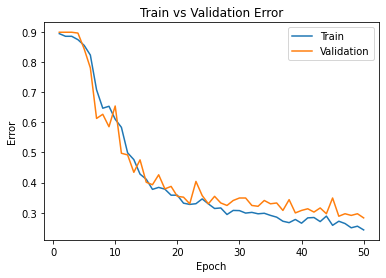

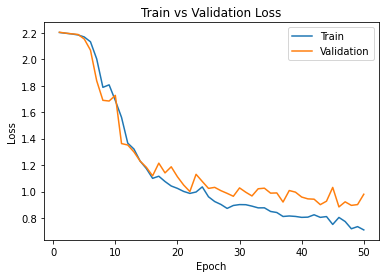

In [ ]:
model_path3 = get_model_name("HandGesture", batch_size=64, learning_rate=0.001, epoch=49)
plot_training_curve(model_path3)

Notice that we are not overfitting anymore but the validation curve is still unstable.

**HYPERPARAMETER SETTINGS 3: new convolutional and pooling layers added to improve the learning of the features**


In [ ]:
class HandGestureClassifer2(nn.Module):
  def __init__(self):
    super(HandGestureClassifer2, self).__init__()
    self.name="HandGesture2"
    self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
    self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
    self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
    self.conv3 = nn.Conv2d(10, 15, 5) #in_channels, out_chanels, kernel_size
    self.fc1 = nn.Linear(15*24*24, 32)
    self.fc2 = nn.Linear(32, 9)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 15*24*24)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
HandGestureNet=HandGestureClassifer2()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_net(HandGestureNet, batch_size=64, learning_rate=0.01, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch 1: Train err: 0.8907809747504404, Train loss: 2.2000681029425726 |Validation err: 0.8873626373626373, Validation loss: 2.20007594426473
Epoch 2: Train err: 0.8819729888432178, Train loss: 2.1973319671772145 |Validation err: 0.8846153846153846, Validation loss: 2.200363357861837
Epoch 3: Train err: 0.8825601879036994, Train loss: 2.194995473932337 |Validation err: 0.8543956043956044, Validation loss: 2.1993149518966675
Epoch 4: Train err: 0.8667058132706987, Train loss: 2.1751524165824607 |Validation err: 0.739010989010989, Validation loss: 2.126201868057251
Epoch 5: Train err: 0.825014679976512, Train loss: 2.1484048984668873 |Validation err: 0.8928571428571429, Validation loss: 2.1962597767512
Epoch 6: Train err: 0.7451556077510275, Train loss: 1.9920119886045102 |Validation err: 0.5879120879120879, Validation loss: 1.665441870689392
Epoch 7: Train err: 0.5490311215502055, Train loss: 1.554371997162148 |Validation err: 0.510989010989011, V

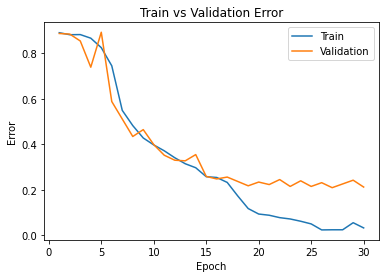

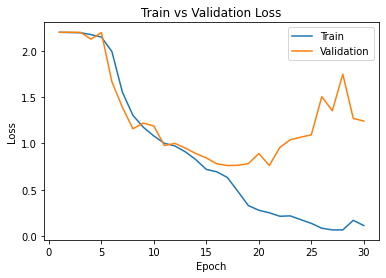

In [ ]:
model_path4 = get_model_name("HandGesture2", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path4)

This model is good, but the loss of the validation starts increasing after 23 epochs, we could try decreasing the number of epochs to prevent overfitting.

**HYPERPARAMETER SETTINGS 4: increasing learning rate, decreasing number of epochs**

In [ ]:
HandGestureNet=HandGestureClassifer()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  HandGestureNet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_net(HandGestureNet, batch_size=64, learning_rate=0.02, num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 1: Train err: 0.8901937756899589, Train loss: 2.2024675916742393 |Validation err: 0.8983516483516484, Validation loss: 2.193366010983785
Epoch 2: Train err: 0.7721667645331768, Train loss: 2.06234081586202 |Validation err: 0.6758241758241759, Validation loss: 1.7680445710817974
Epoch 3: Train err: 0.5161479741632413, Train loss: 1.4576033177199188 |Validation err: 0.4697802197802198, Validation loss: 1.213594138622284
Epoch 4: Train err: 0.4180857310628303, Train loss: 1.2072442394715768 |Validation err: 0.478021978021978, Validation loss: 1.3369403680165608
Epoch 5: Train err: 0.37991779213153254, Train loss: 1.0670651727252536 |Validation err: 0.39560439560439564, Validation loss: 1.105053832133611
Epoch 6: Train err: 0.3529066353493835, Train loss: 0.9880242767157378 |Validation err: 0.37362637362637363, Validation loss: 1.035982261101405
Epoch 7: Train err: 0.2842043452730476, Train loss: 0.8418884807162814 |Validation err: 0.3461538461

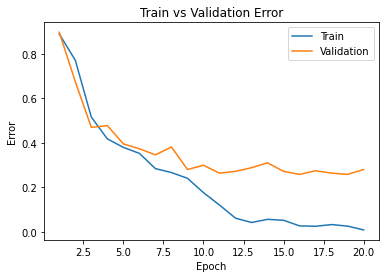

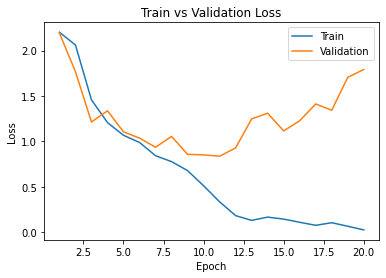

In [ ]:
model_path5 = get_model_name("HandGesture", batch_size=64, learning_rate=0.02, epoch=19)
plot_training_curve(model_path5)

The model I will chooose is the one that gives the lowest validation error, and does not show an overfitting in the training dataset. For this reason, the best model out of all the ones I trained is: HandGestureClassifier2 with train_net(HandGestureNet, batch_size=64, learning_rate=0.01, num_epochs=30)

In [ ]:
net = HandGestureClassifer2()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  net.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

model_path6 = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=26)
state = torch.load(model_path6)
net.load_state_dict(state)

train_loader, val_loader, test_loader= get_data_loader(batch_size=64)

evaluate(net, test_loader, nn.CrossEntropyLoss())

CUDA is available!  Training on GPU ...


(0.18406593406593408, 1.2579995095729828)

The prediction for the testing data has an accuracy of 82%, which is good.

### Transfer Learning

For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data. It is better to use transfer learning. 

Convolution layers extract various features from the images which get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal role in establishing Deep Neural Nets as a go-to tool for image classification problems and I will use an ImageNet pre-trained AlexNet model to extract features in this code.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 where N is the batch size.

In [ ]:
def feature_extraction(dataset): #this function will extract the features for any of the datasets we have, training, validation and testing.

  data_loader=torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)

  features=[]

  for i, labels in iter(data_loader):
    imgs=alexnet.features(i)
    features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
    labels=torch.stack([j for j in labels])
    features.append((features_only,labels))

  return features #this turns a list of tensors that are the images and the labels

In [ ]:
features1=feature_extraction(train_sampler)
features2=feature_extraction(val_sampler)
features3=feature_extraction(test_sampler)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#print(features1) if we want to display them we could this way
#print(features2)
#print(features3)

Since the AlexNet practically computes the features, I would no longer need convolutional and pooling layers to consolidate the information regarding the features present in the images (we could add for more details but this could overfit). For this reason, I only included fully connected layers that receive the features from the AlexNet as inputs and predicts which class the images are in.

Since the size of the features is 256x6x6, this will be the input size of the first layer, and the output is 10 and the output of the second layer is 9, each representing one of the classes (hand gestures). This number could be increased but my model performed well with 2 layers.

In [ ]:
class AlexNetClassifier(nn.Module):
    def __init__(self):
        super(AlexNetClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 15)
        self.fc2 = nn.Linear(15, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Training Code

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = features1
    else:
        data_loader = features2
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, features, batch_size=64, num_epochs=1):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 
    for epoch in range(num_epochs):
        for imgs, labels in iter(features):
            imgs = torch.from_numpy(imgs.detach().numpy())
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iters.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True)) 
            val_acc.append(get_accuracy(model, train=False))
            n += 1

    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is not available.  Training on CPU ...


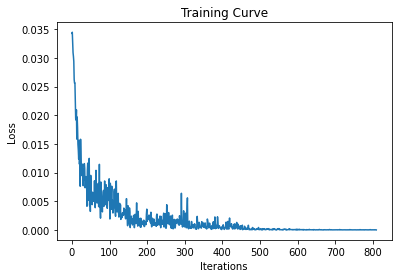

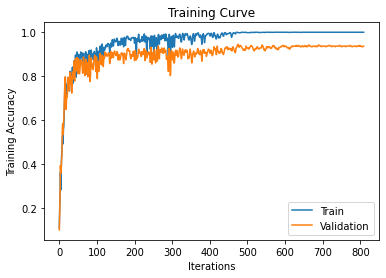

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9368131868131868


In [ ]:
import matplotlib.pyplot as plt

use_cuda = True

model = AlexNetClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(model, features1, num_epochs=30)

#### Testing Set

In [ ]:
def get_accuracy(model, features):
    correct = 0
    total = 0
    for imgs, labels in features:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
get_accuracy(model,features3)

0.9285714285714286

The test accuracy is 0.928 (>90%) which is similar to the one for validation. This is a good indication. This performs way better than the model we had in part 3(d) without transfer learning (only 82%). This is because AlexNet had already been trained on large datasets and can retrieve the important features more than the model we manually create with convolutional, pooling and fully connected layers. This shows how useful transfer learning is. Also, the training takes much less time.

#### Testing on New Data

I took some sample images of my hands to test the performance of the best model developed.

In [ ]:
features4=feature_extraction(dataset2)

In [ ]:
import pandas as pd

accurate_results=[]
correct = 0
total = 0
for imgs, labels in features4:
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  output = model(imgs)
        
  pred = output.max(1, keepdim=True)[1]
  pred=pred.cpu()
  pred2=(pred.detach().numpy()).reshape(1,-1)[0]
  labels=labels.cpu()
  labels2=(labels.detach().numpy()).reshape(1,-1)[0]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  total += imgs.shape[0]
print("Accuracy of my predicting the pictures of my hands is:", correct/total)

for i in range(27):
  if pred2[i]==labels2[i]:
    accurate_results.append(labels2[i])

unique, counts = np.unique(accurate_results, return_counts=True)
accurate_results=(counts/3).reshape(-1,1)
gestures=np.array(['I','G','A','F','H','C','D','E','B']).reshape(-1,1) #I got this order from when we unzipped the folders
gestures_final=np.concatenate((gestures,accurate_results),axis=1)
gestures_result=pd.DataFrame(gestures_final,columns=['Hand Gestures','Accuracy'])
gestures_result=gestures_result.sort_values('Hand Gestures', ascending=True,ignore_index=True)
print()
print(gestures_result)

Accuracy of my predicting the pictures of my hands is: 0.9259259259259259

  Hand Gestures            Accuracy
0             A                 1.0
1             B  0.6666666666666666
2             C                 1.0
3             D  0.6666666666666666
4             E                 1.0
5             F                 1.0
6             G                 1.0
7             H                 1.0
8             I                 1.0


The reason why my model did not perform so well in handgestures B and D is because the pictures of my hands had nail polish and a ring on, which is something very rare to have been seen in the training data. Specifically in these letters, the nails are showing more than the others which could have made the model miss the handgestures. However, the model performed good (accuracy of 0.925) which is indicative that it learned well in the transfer learning part.